### Spotify API - Client Credentials flow
The [Spotify Web API](https://developer.spotify.com/documentation/web-api/) is similar to the Twitter v2 API in several ways. However, the main difference is how the access token is generated.

Instead of getting the bearer token from the approved app (like on Twitter), Spotify generates a new bearer token every 60 minutes. To make requests from the API, you first need to generate a token for the session and then use that token when making specific requests. Every 60 minutes, you will need to refresh the session token.

For this example, we are going to use a process Spotify calls the ["Client Credentials Flow"](https://developer.spotify.com/documentation/general/guides/authorization-guide/#authorization-code-flow) which is simpler than the other authorization flows, but is more limited in the data that can be retrieved (only non-user endpoints are available).

##### Client Credentials Flow
This process only requires an app Client ID and Client Secret. These are generated by creating a new app.
- Step 1. Navigate to the [Spotify Developer Dashbaord](https://developer.spotify.com/dashboard/login) and login. You will need to have a Spotify account to log in.
- Step 2. Click Create an App and enter an app name and description. Unlike Twitter, there is no approval process for the app or use case.

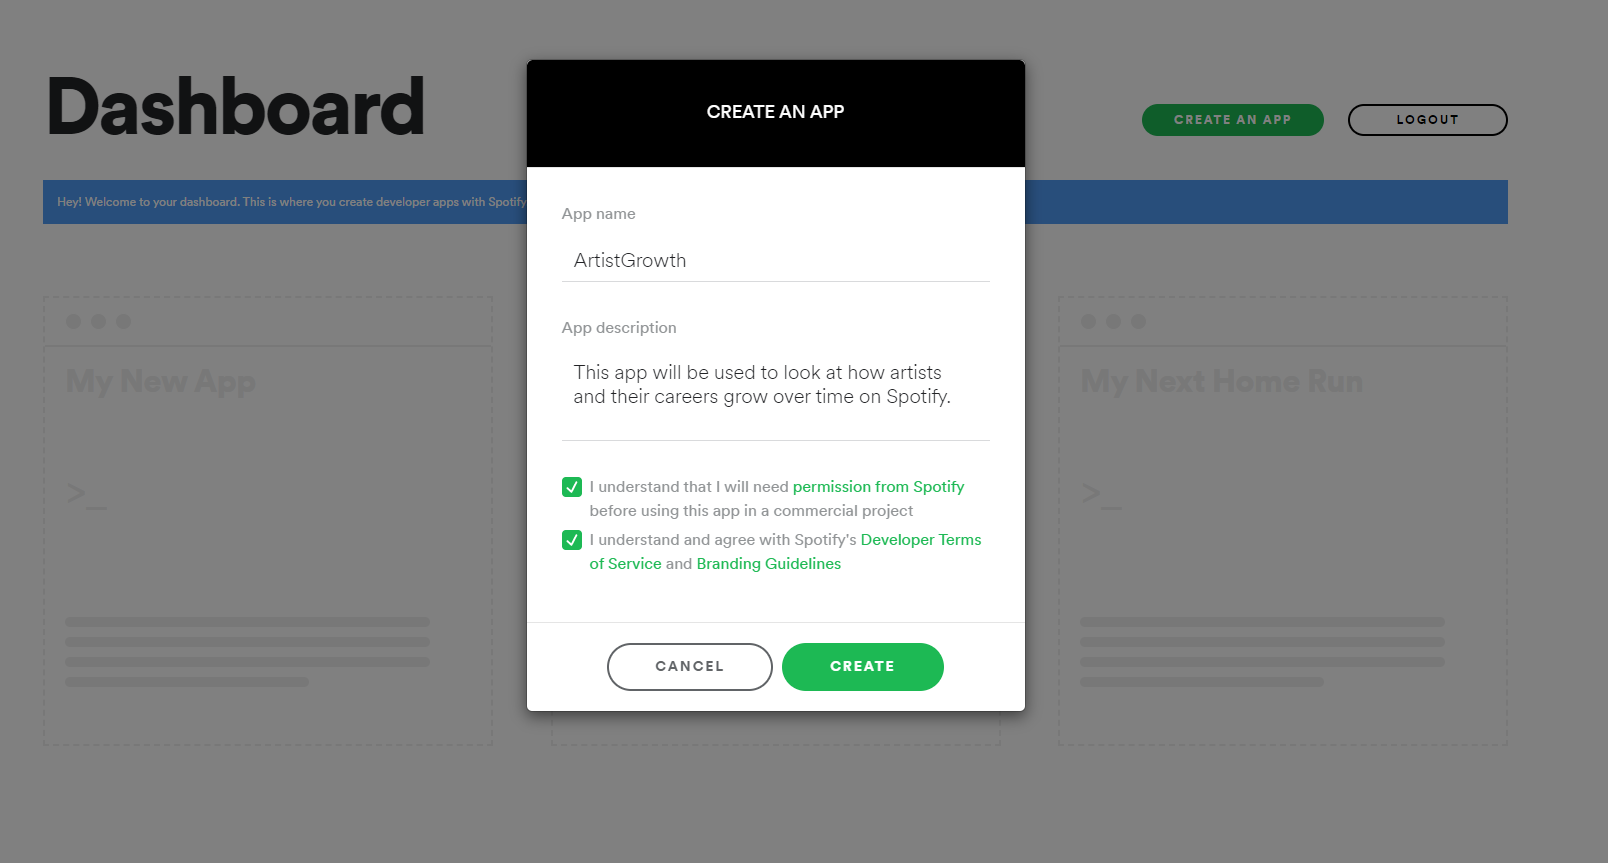

- Step 3. Copy and save the Client ID and Client Secret to a tab separated text file, like we did for the Twitter bearer token.

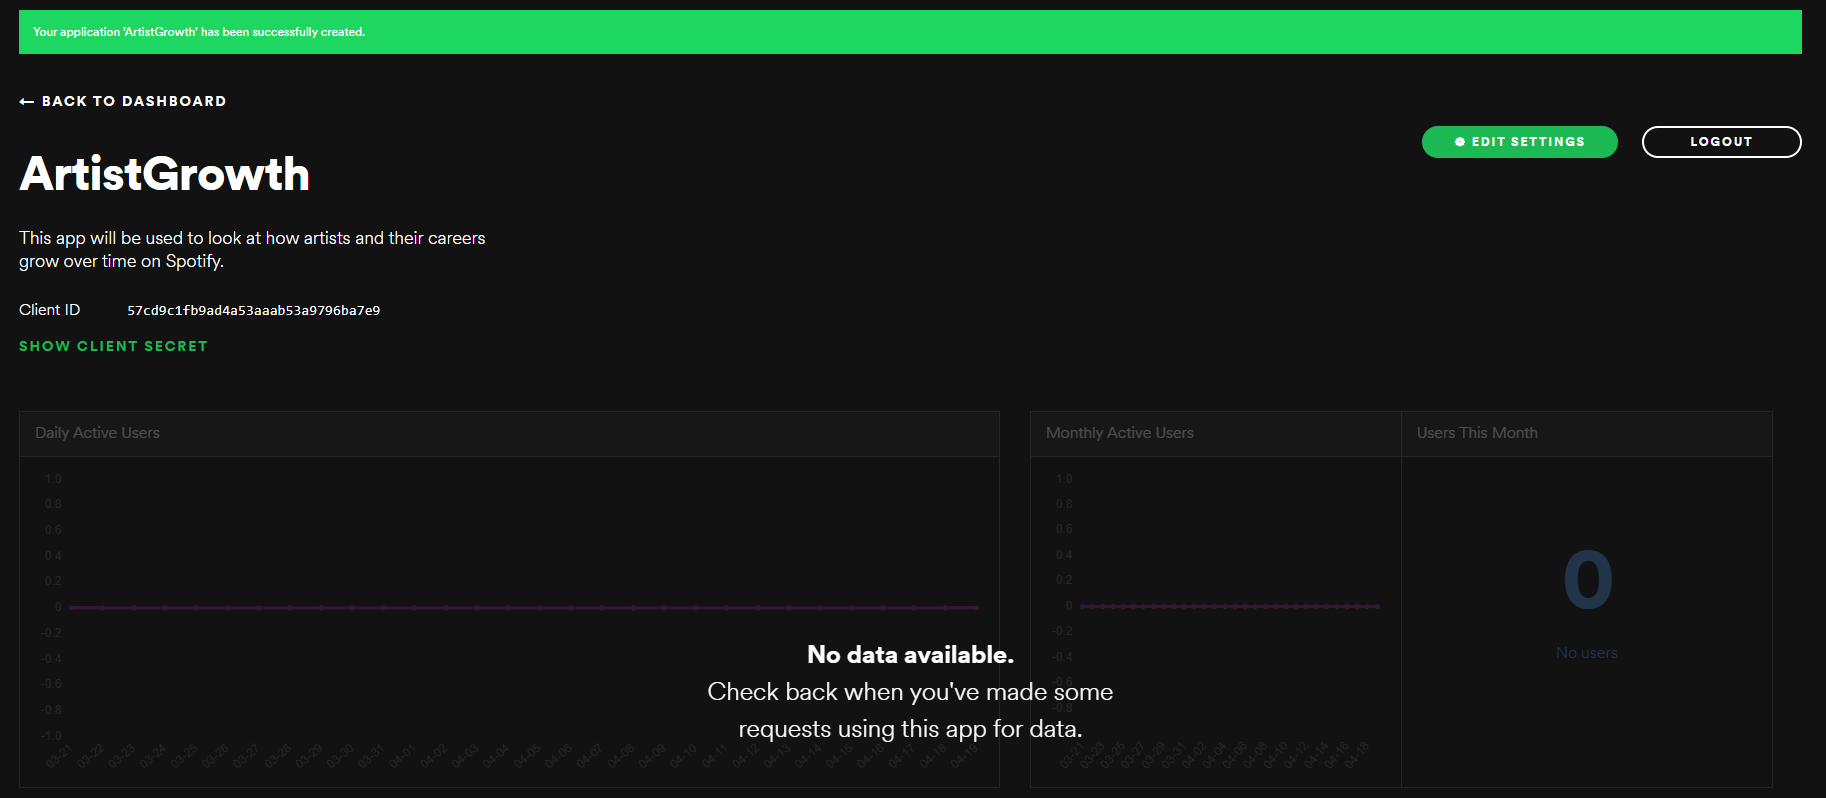

For this example, I've saved the text file in the same folder as my Jupyter Notebook environment. If you save it somewhere else, you will need to specify the file path like we have done with other data files.

With this info, we can generate the session token. We will use a few packages to help translate our requests to the format recognized by the Web API. If you are interested in all the details, check out the [Authorization Guide](https://developer.spotify.com/documentation/general/guides/authorization-guide/) document. Scroll down to the Client Credentials Flow header toward the bottom.

In [1]:
import requests
import base64
import six
import json
import pandas as pd

In this notebook, I've commented out any place where my app's keys, tokens, and secrets may show up. When you run this code, uncomment these lines to test to make sure everything is working.

In [2]:
tokens = pd.read_csv('Spotify-Keys_4.20.21.txt', sep = '\t', header = None).T
tokens.columns = tokens.iloc[0]
tokens = tokens[1:]
#tokens.Client_Secret[1]

With the Client ID and Client Secret available in our environment, we can now build a function to generate the correct headers to get the session token. The main difference between this an the Twitter functions is that the encoding is different. Twitter required URL encoding (also called [percent-encoding](https://en.wikipedia.org/wiki/Percent-encoding)). To get the session token, the client info is posted to the authorization server, which requires the data to be encoded in [Base64](https://en.wikipedia.org/wiki/Base64).

After testing the `start_session_headers()` function, you should see output that looks like:
`{'Authorization': 'Basic NTd...='}` where `NTd...=` is replaced with your unique key.

In [3]:
def start_session_headers(client_id, client_secret):
    client_cred = base64.b64encode(six.text_type(client_id + ":" + client_secret).encode("ascii"))
    headers = {"Authorization": "Basic %s" % client_cred.decode("ascii")}
    return headers

#print(start_session_headers(tokens.Client_ID[1], tokens.Client_Secret[1]))

This next function "posts" a `payload` that specifies the type of authorization requests along with the start session headers. The conditional statement parses any errors received should something go wrong.

In [4]:
def connect_to_client_cred(url, headers):
    payload = {'grant_type' : 'client_credentials'}
    response = requests.request("POST", url, headers = headers, data = payload)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

Finally, we are able to put all the pieces together to generate a session access token. We make a POST request to the url "https://accounts.spotify.com/api/token" along with the headers and payload.

The commented out line is if you want to display the response (like we did with the Twitter data). Instead, I want to save the response as a dictionary so that I can call the access_token when we make requests for data.

In [5]:
def get_access_token():
    #Uses the Client Credentials flow, no access to endpoints with user data
    url = "https://accounts.spotify.com/api/token"
    header = start_session_headers(tokens.Client_ID[1], tokens.Client_Secret[1])
    json_response = connect_to_client_cred(url, header)

    #return json.dumps(json_response, indent = 4, sort_keys = True)
    return json_response

In [6]:
session_token = get_access_token()

200


If all goes well, calling `session_token` will return a dictionary that looks like:

`{'access_token': 'BQ...go',
 'token_type': 'Bearer',
 'expires_in': 3600}`
 
 where `'BQ...go'` will be replaced with a string ~80 characters long.

In [7]:
#session_token

In [8]:
#session_token['access_token']

Now we go back to the the functions that we used for the Twitter API. First is to create the header to go with the requests.

In [9]:
def create_header(session_token):
    headers = {"Authorization": "Bearer {}".format(session_token)}
    return headers

#create_header(session_token['access_token'])

In [10]:
def connect_to_endpoint(url, headers):
    response =requests.request("GET", url, headers = headers)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In general, the urls for the Spotify Web API are simpler than those for Twitter. Instead of a create_url function, we are just going to define a few functions that connect to specific endpoints. Here, I am connecting to the [Get Audio Features for a Track](https://developer.spotify.com/documentation/web-api/reference/#category-tracks) and the [Get an Album](https://developer.spotify.com/documentation/web-api/reference/#category-albums) endpoints.

For the urls, the id is used to specify what tracks or albums you want the information from. These can be wither single IDs or multiple IDs separated by a comma.

In [11]:
def track_audio_features(id):
    url = 'https://api.spotify.com/v1/audio-features/{}'.format(id)
    header = create_header(session_token['access_token'])
    json_response = connect_to_endpoint(url, header)
    return json_response

In [12]:
def get_an_album(id):
    url = 'https://api.spotify.com/v1/albums/{}'.format(id)
    header = create_header(session_token['access_token'])
    json_response = connect_to_endpoint(url, header)
    return json_response

I just happened to be listening to Julia Michaels when writing this notebook, so I grabbed the album URI that looks like: spotify:album:2f4Ejh4Po2rpuXSYa6IDCe.
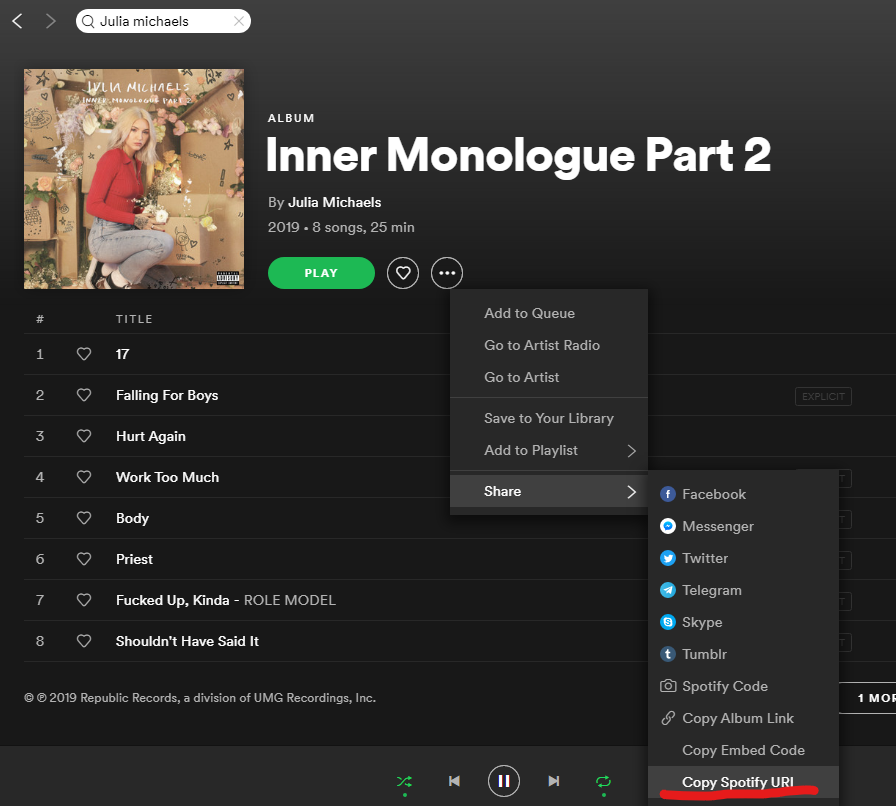
The part after album: is the ID we can pass to our function.

In [13]:
album = get_an_album('2f4Ejh4Po2rpuXSYa6IDCe')

200


You should take a look at the data like that is returned and refer to the [Objects Index](https://developer.spotify.com/documentation/web-api/reference/#objects-index) for a description of each of the keys and values.

In [14]:
#album

In [15]:
album.keys()

dict_keys(['album_type', 'artists', 'available_markets', 'copyrights', 'external_ids', 'external_urls', 'genres', 'href', 'id', 'images', 'label', 'name', 'popularity', 'release_date', 'release_date_precision', 'total_tracks', 'tracks', 'type', 'uri'])

Each track in the album has a track ID. We can use this and list comprehension to get the audio features for each track in the album. Each audio feature is also defined in the Objects Index document. Look for "AudioFeaturesObject." For example, "dancability" is "... how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."

In [16]:
album['tracks']['items'][0]['id']

'0ND8rF8oirMXtE59n585P6'

In [17]:
audio_features = [track_audio_features(x['id']) for x in album['tracks']['items']]

200
200
200
200
200
200
200
200


In [18]:
#audio_features

From here, you can define your own functions based on the endpoints you are most interested in. You will also need to work out the analysis portion of the project. For example, the audio features may need to be transformed to a pandas DataFrame. Thankfully, a list of dictionaries is easy for the `pd.DataFrame()` function to parse.

In [19]:
audio_features_df = pd.DataFrame(audio_features)
audio_features_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.774,0.466,4,-6.869,1,0.0433,0.458,0.000000,0.1110,0.396,97.975,audio_features,0ND8rF8oirMXtE59n585P6,spotify:track:0ND8rF8oirMXtE59n585P6,https://api.spotify.com/v1/tracks/0ND8rF8oirMX...,https://api.spotify.com/v1/audio-analysis/0ND8...,182800,4
1,0.646,0.485,0,-6.647,1,0.0829,0.501,0.000000,0.1210,0.408,148.130,audio_features,5AmTHXOp1sTFkYZBRBQ7zt,spotify:track:5AmTHXOp1sTFkYZBRBQ7zt,https://api.spotify.com/v1/tracks/5AmTHXOp1sTF...,https://api.spotify.com/v1/audio-analysis/5AmT...,183720,4
2,0.826,0.701,4,-4.176,0,0.0495,0.251,0.000002,0.0936,0.784,129.977,audio_features,3JPXFD2aJ4dHPMnGwo41bO,spotify:track:3JPXFD2aJ4dHPMnGwo41bO,https://api.spotify.com/v1/tracks/3JPXFD2aJ4dH...,https://api.spotify.com/v1/audio-analysis/3JPX...,202320,4
3,0.563,0.722,0,-4.638,1,0.0664,0.153,0.000000,0.0791,0.317,95.003,audio_features,508FoYYfy1YjC6ZVUMctZJ,spotify:track:508FoYYfy1YjC6ZVUMctZJ,https://api.spotify.com/v1/tracks/508FoYYfy1Yj...,https://api.spotify.com/v1/audio-analysis/508F...,197347,4
4,0.540,0.409,8,-6.658,1,0.0284,0.781,0.000000,0.1040,0.197,95.177,audio_features,2GmPIJzviXYtkTKYYUlloB,spotify:track:2GmPIJzviXYtkTKYYUlloB,https://api.spotify.com/v1/tracks/2GmPIJzviXYt...,https://api.spotify.com/v1/audio-analysis/2GmP...,180293,4
